In [1]:
# Check for bls_key (API registration key) in config.py. 
# These calls will work without it but will be more limited on how many can be made
# BLS: https://www.bls.gov/developers/api_FAQs.htm#register1
try:
    from config import bls_key
    registered = True
except (ImportError):
        registered = False
        print("No API key found in config.py: Daily data pulls more limited")


In [25]:
# Dependencies & Setup to work with BLS
# Note there is a limit to how many free pulls may be done in a day from BLS: https://www.bls.gov/developers/api_FAQs.htm#register1

import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path 
from scipy.stats import linregress

base_url = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'
headers = {'Content-type': 'application/json'}

#Set url based on whether API key is available or not. 
if registered:
    url = base_url+"?registrationkey="+bls_key
else:
    url = base_url

# BLS Series IDs are built on a prefix specific to the data series available + location + suffix structure
# BLS City codes: 
city_codes = {"Austin":"CT4805000000000", "Chicago":"CT1714000000000", "Denver":"CT0820000000000",
              "Memphis":"CT4748000000000", "New York":"CT3651000000000", "San Francisco":"CT0667000000000"}
# BLS State codes + 00000 for "all areas":
state_codes = {"Texas":"4800000", "Illinois":"1700000", "Colorado":"0800000",
               "Tennessee":"4700000", "New York":"3600000", "California":"0600000"}
# prefix codes unadjsted for seasonal periods
prefix_codes = {"Unemployment":"LAU", "Non-Farm Job Openings":"JTU000000"}
# depending on the prefix, the suffix are different lengths and mean different things
suffix_codes = {"Unemployment Rate":"03", "All Size Job Openings Rate":"00JOR"}
    
# BLS queries all have a start and end year input; using constants at this level to have consistent time period reporting
startyear = 2020
endyear = 2022

In [6]:
# Define function to request results from BLS
# arguments: id_list = list of IDs to query data
# returns: json formatted data for the input series

def request_bls_results_json(id_list):
    data = json.dumps({"seriesid":id_list,"startyear":startyear, "endyear":endyear})
    req = requests.post(url, data=data, headers=headers)
    data = json.loads(req.text)

    # Print response characteristics to identify potential issues such as maximizing allowed queries in a day
    print(req)
    print(f"Request Status {data['status']}")
    print(f"Request Message {data['message']}")

    # Reduce to just the results series of data if it was pulled
    try:
        data_core = data["Results"]["series"]
        return(data_core)
    except (KeyError, IndexError):
        print("-----------------------")
        print("!! No Data Available !!")
        print("-----------------------")
        return("")

In [19]:
# Define function to create a DataFrame for Unemployment Rates Over Time
# arguments: json_list = downloaded list of results in json format
#            loc_dict = dictionary of locations
#            loc_start = location start index in Series ID (3, 9)
#            loc_end = location end index in Series ID (-2, -5)
# returns: data frame with location as header and time periods as index

def create_bls_numeric_df(json_list,loc_dict,loc_start,loc_end):
    # Create empty lists to hold data collected from json output
    loc_list = []
    time_periods = []
    result_list = []

    # Iterate through location data (json data is setup as a list of data by SeriesID (which is includes location))
    for i in range(len(json_list)):

        # trim the series ID to pull out the location code and programmatically populate location rather than relying on original input staying in same order
        loc_value = json_list[i]["seriesID"][loc_start:loc_end]
        # Reference for pulling dictionary key from known value: https://www.geeksforgeeks.org/python-get-key-from-value-in-dictionary/
        loc_key = list(filter(lambda c: loc_dict[c] == loc_value, loc_dict))[0]
        loc_list.append(loc_key)
        # Setup list for time period and results to be used for single location
        tp = []
        rl = []
        # Pull out the time period and result value storing them in the single location list
        for j in range(len(json_list[i]["data"])):
            tp.append(json_list[i]["data"][j]["year"]+" "+json_list[i]["data"][j]["period"])
            rl.append(json_list[i]["data"][j]["value"])

        # Convert the results from string to number
        rl_num = list(map(float, rl))

        # Reverse lists to be oldest to newest
        tp_rev = tp[::-1]
        rl_num_rev = rl_num[::-1]

        # Add the single location lists into the overall lists
        time_periods.append(tp_rev) # This should be the same for each city based on common output
        result_list.append(rl_num_rev) # This will be different for each city

    # iterate through the city and rate lists as columns to use pandas plot with lines per city
    data_dict = {}
    for i in range(len(loc_list)):
        data_dict[loc_list[i]] = result_list[i]

    data_df = pd.DataFrame(data_dict, index=time_periods[0])
    return(data_df)

In [12]:
# Request Unemployment Rate (a monthly output by year by city, county, state, area depending on your ID)

# Create list of Series IDs for unemployment rate
unemp_series = []
for city in city_codes:
    unemp_series.append(prefix_codes["Unemployment"] + city_codes[city] + suffix_codes["Unemployment Rate"])

# Call function to get json results
unemp_data_results = request_bls_results_json(unemp_series)

# Save response data to file to reduce need to re-request due to limitations
unemp_file = Path("resources/unemployment.txt")
with open(unemp_file, 'w') as convert_file:
     convert_file.write(json.dumps(unemp_data_results))

In [20]:
# Create a DataFrame for Unemployment Rates Over Time
loc_start = 3  # Unemployment prefix is 3 letter
loc_end = -2   # Unemployment suffix is 2 letters

unemp_df = create_bls_numeric_df(unemp_data_results,city_codes,loc_start,loc_end)

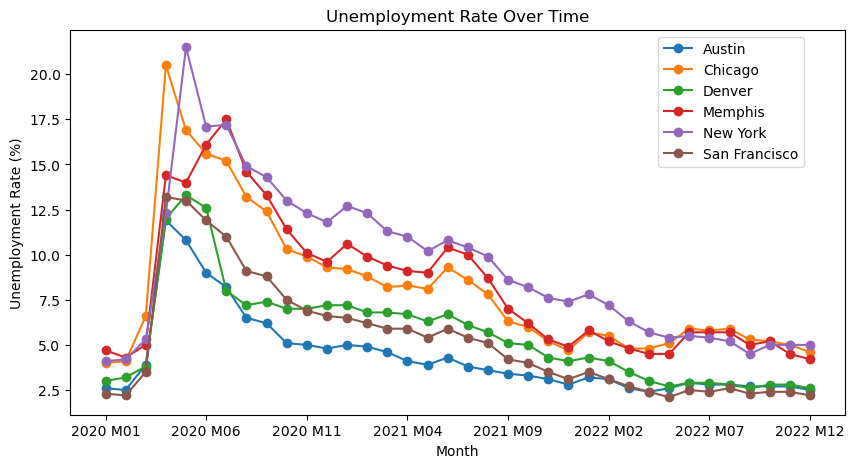

In [119]:
# Create plot with legend to the side of the plot
unemp_plot = unemp_df.plot.line(figsize=(10, 5), marker="o", xlabel="Month", ylabel="Unemployment Rate (%)", title="Unemployment Rate Over Time")
plt.legend(bbox_to_anchor=(0.75,1.0), loc="upper left")

# Save the figure
plt.savefig("output_data/UnemploymentRate.png")

# Show plot
plt.show()

In [27]:
# Request Job Opening Rate (a monthly output by year by city, county, state, area depending on your ID)

# Create list of Series IDs for job openings rate (only at state level)
jobopen_series = []
for state in state_codes:
    jobopen_series.append(prefix_codes["Non-Farm Job Openings"] + state_codes[state] + suffix_codes["All Size Job Openings Rate"])

# Call function to get json results
jobopen_data_results = request_bls_results_json(jobopen_series)

# Save response data to file to reduce need to re-request due to limitations
jobopen_file = Path("resources/job_openings.txt")
with open(jobopen_file, 'w') as convert_file:
     convert_file.write(json.dumps(jobopen_data_results))

<Response [200]>
Request Status REQUEST_SUCCEEDED
Request Message []


In [28]:
# Create a DataFrame for Job Opening Rates Over Time
loc_start = 9  # Unemployment prefix is 9 letter
loc_end = -5   # Unemployment suffix is 5 letters

jobopen_df = create_bls_numeric_df(jobopen_data_results,state_codes,loc_start,loc_end)

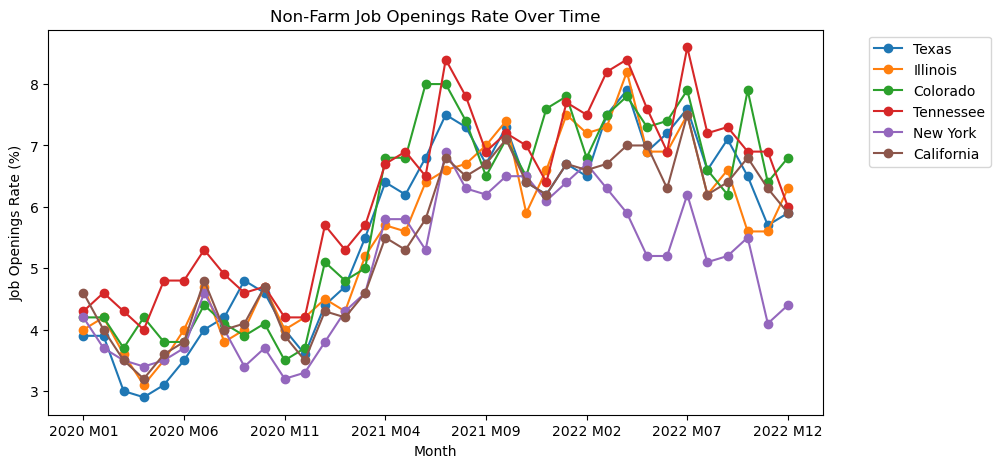

In [115]:
# Create plot with legend to the side of the plot
jobopen_plot = jobopen_df.plot.line(figsize=(10, 5), marker = "o", xlabel="Month", ylabel="Job Openings Rate (%)", title="Non-Farm Job Openings Rate Over Time")
plt.legend(bbox_to_anchor=(1.05,1.0), loc="upper left")

# Save the figure
plt.savefig("output_data/JobOpeningsRate.png")

# Show plot
plt.show()

In [110]:
# Define a function to create Linear Regression plots and use matplotlib to create scatter and line plots
def lin_regress_plot(x, y_label, c):
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, jobopen_df[y_label])
    regress_values = slope*x_axis + intercept
    plt.scatter(x, jobopen_df[y_label], color=c, alpha=0.5)
    plt.plot(x, regress_values, color=c, label=y_label)
    return

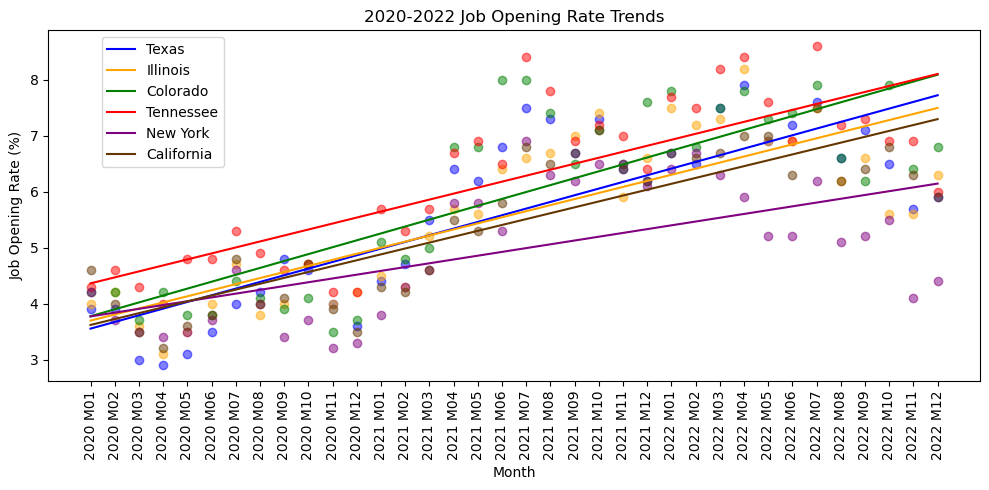

In [120]:
# Create Job Opening scatter plot with linear regression by state

# Set x axis, tick locations, figure size
x_axis = range(len(jobopen_df))
tick_locations = [value for value in x_axis]
plt.figure(figsize=(10,5))
plt.xticks(tick_locations, jobopen_df.index, rotation="vertical")

# Set labels
plt.title("2020-2022 Job Opening Rate Trends")
plt.xlabel("Month")
plt.ylabel("Job Opening Rate (%)")

# Plot Texas job opening scatter with linear regression line
lin_regress_plot(x_axis, "Texas", "blue")

# Plot Illinois job opening scatter with linear regression line
lin_regress_plot(x_axis, "Illinois", "orange")

# Plot Colorado job opening scatter with linear regression line
lin_regress_plot(x_axis, "Colorado", "green")

# Plot Tennessee job opening scatter with linear regression line
lin_regress_plot(x_axis, "Tennessee", "red")

# Plot New York job opening scatter with linear regression line
lin_regress_plot(x_axis, "New York", "purple")

# Plot California job opening scatter with linear regression line
lin_regress_plot(x_axis, "California", "#653700")

# Add legend and tighten plot
plt.legend(bbox_to_anchor=(0.05,1.0), loc="upper left")
plt.tight_layout()

# Save the figure
plt.savefig("output_data/JobOpeningsTrend.png")

plt.show()